**<h2 style="text-align: center; color:#33FF33;">CHURN CLASSIFY WITH NON PURCHASE USERS</h2>**

#### **Neccessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics  import mutual_info_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,classification_report,
    confusion_matrix, roc_curve, auc, brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### **Read and explore data**

#### **Read data**

In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'},parse_dates=['last_update_time'])
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_equip=pd.read_csv("../EDA_transform/data/equipenhance_transform_cluster.csv",dtype={'vopenid':'object'})
df_regis=pd.read_csv("../EDA_transform/data/register_transform.csv",dtype={'vopenid':'object'})

df_purchase.columns = df_purchase.columns.str.strip()
df_equip.columns = df_equip.columns.str.strip()
df_purchase['last_update_time'] = pd.to_datetime(df_purchase['last_update_time'], errors='coerce', utc=True)
df_equip['last_update_time'] = pd.to_datetime(df_equip['last_update_time'], errors='coerce', utc=True)

df_login.shape,df_purchase.shape,df_equip.shape

((201416, 19), (37259, 9), (55138, 10))

In [3]:
df_login.info(),df_login['last_update_time'].min(),df_login['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201416 entries, 0 to 201415
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   vopenid                201416 non-null  object             
 1   last_update_time       201416 non-null  datetime64[ns, UTC]
 2   num_day_login          201416 non-null  int64              
 3   login_frequency        201416 non-null  float64            
 4   avg_between_login      201416 non-null  float64            
 5   streak_login           201416 non-null  int64              
 6   last_since_from_login  201416 non-null  int64              
 7   popular_time_login     201416 non-null  int64              
 8   gold_std_login         201416 non-null  float64            
 9   diamond_std_login      201416 non-null  float64            
 10  silkcoin_std_login     201416 non-null  float64            
 11  gold_slope_login       201416 non-null 

(None,
 Timestamp('2025-05-03 16:08:43+0000', tz='UTC'),
 Timestamp('2025-06-19 23:59:59+0000', tz='UTC'))

In [4]:
df_purchase.info(),df_purchase['last_update_time'].min(),df_purchase['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37259 entries, 0 to 37258
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   vopenid                   37259 non-null  object             
 1   last_update_time          37169 non-null  datetime64[ns, UTC]
 2   num_purchase              37259 non-null  int64              
 3   total_purchase            37259 non-null  float64            
 4   count_purchase_per_day    37259 non-null  float64            
 5   std_amount_purchase       37259 non-null  float64            
 6   max_purchase              37259 non-null  float64            
 7   days_since_last_purchase  37259 non-null  int64              
 8   num_product_buyed         37259 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(1)
memory usage: 2.6+ MB


(None,
 Timestamp('2025-05-01 00:07:24.302000+0000', tz='UTC'),
 Timestamp('2025-06-25 23:59:55.587000+0000', tz='UTC'))

In [5]:
df_equip.info(),df_equip['last_update_time'].min(),df_equip['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55138 entries, 0 to 55137
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   vopenid               55138 non-null  object             
 1   last_update_time      55138 non-null  datetime64[ns, UTC]
 2   num_enhance           55138 non-null  int64              
 3   enhance_success_rate  55138 non-null  float64            
 4   max_enhance_level     55138 non-null  int64              
 5   tsne_1                55138 non-null  float64            
 6   tsne_2                55138 non-null  float64            
 7   tsne_gmm_1            55138 non-null  float64            
 8   tsne_gmm_2            55138 non-null  float64            
 9   equi_beha             55138 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(2)
memory usage: 4.2+ MB


(None,
 Timestamp('2025-05-03 17:00:34+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:58+0000', tz='UTC'))

In [6]:
df_regis.info(),df_regis['last_update_time'].min(),df_regis['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99270 entries, 0 to 99269
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   vopenid              99270 non-null  object
 1   last_update_time     99270 non-null  object
 2   days_since_register  99270 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


(None, '2025-05-01 00:00:28.354000+00:00', '2025-06-18 23:59:59.461000+00:00')

#### **Merge data**

In [7]:
df_login = df_login.rename(columns={'last_update_time': 'last_update_time_login'})
df_purchase = df_purchase.rename(columns={'last_update_time': 'last_update_time_purchase'})
df_equip = df_equip.rename(columns={'last_update_time': 'last_update_time_equip'})

users_with_purchase = set(df_purchase['vopenid'].unique())
df_login_non_purchase = df_login[~df_login['vopenid'].isin(users_with_purchase)].copy()

df_merged = df_login_non_purchase.merge(
    df_equip[['vopenid', 'equi_beha']],
    on='vopenid',
    how='left'
)

print(df_merged.shape)
print(df_merged.head())

(165260, 20)
            vopenid    last_update_time_login  num_day_login  login_frequency  \
0  2206111754266455 2025-05-08 11:08:20+00:00              2             1.00   
1  2206111758351763 2025-05-26 05:07:07+00:00              1             1.00   
2  2206111808105074 2025-06-16 02:01:16+00:00              2             3.00   
3  2206111830413361 2025-06-19 14:54:55+00:00             47             3.49   
4  2206111904162575 2025-05-20 01:58:44+00:00              1             1.00   

   avg_between_login  streak_login  last_since_from_login  popular_time_login  \
0               1.02             2                     42                  10   
1               0.00             1                     24                   5   
2               0.09             2                      3                   1   
3               0.29            36                      0                  22   
4               0.00             1                     30                   1   

   gold_std_l

In [8]:
del df_login
del df_purchase
del df_equip

In [9]:
df_merged=df_merged[df_merged['num_day_login'] >= 1].reset_index(drop=True)
df_merged.shape

(165260, 20)

In [10]:
# print("Before filter:", df_merged.shape)
# print("Regis count:", df_regis['vopenid'].nunique())

# print("Match count:", df_merged['vopenid'].isin(df_regis['vopenid']).sum())


In [11]:
# df_merged = df_merged[df_merged['vopenid'].isin(df_regis['vopenid'])].reset_index(drop=True)
# df_merged.shape

In [12]:
df_merged.head(3)

,vopenid,last_update_time_login,num_day_login,login_frequency,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,short_lifetime_flag,powerpoint_last_login,level_last_login,vip_last_login,churn,equi_beha
0,2206111754266455,2025-05-08 11:08:20+00:00,2,1.00,1.02,2,42,10,12632.46,0.00,0.00,17865.00,0.00,0.00,0,29366,9,0,1,NaN
1,2206111758351763,2025-05-26 05:07:07+00:00,1,1.00,0.00,1,24,5,0.00,0.00,0.00,0.00,0.00,0.00,0,25359,1,0,1,NaN
2,2206111808105074,2025-06-16 02:01:16+00:00,2,3.00,0.09,2,3,1,191511.83,0.41,0.00,61253.34,-0.14,0.00,1,74275,21,0,1,normal


In [13]:
df_merged['equi_beha'] = df_merged['equi_beha'].fillna('not_enhance')

In [14]:
# df_merged['vopenid'] = df_merged['vopenid'].astype(str) + "_" + df_merged["id_win"].astype(str)

In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165260 entries, 0 to 165259
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   vopenid                 165260 non-null  object             
 1   last_update_time_login  165260 non-null  datetime64[ns, UTC]
 2   num_day_login           165260 non-null  int64              
 3   login_frequency         165260 non-null  float64            
 4   avg_between_login       165260 non-null  float64            
 5   streak_login            165260 non-null  int64              
 6   last_since_from_login   165260 non-null  int64              
 7   popular_time_login      165260 non-null  int64              
 8   gold_std_login          165260 non-null  float64            
 9   diamond_std_login       165260 non-null  float64            
 10  silkcoin_std_login      165260 non-null  float64            
 11  gold_slope_login        16

#### **Set churn**

In [16]:
now = pd.Timestamp('2025-06-26 23:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time_login']).dt.days

In [17]:
# df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

In [18]:
# df_merged['churn'] = (df_merged['days_since_last_login'] > 7).astype(int) # true is one
# df_merged[['vopenid','last_update_time_login','churn']].head(20)

In [19]:
df_merged['churn'].value_counts()

churn
1    91374
0    73886
Name: count, dtype: int64

In [20]:
df_merged.columns

Index(['vopenid', 'last_update_time_login', 'num_day_login', 'login_frequency',
       'avg_between_login', 'streak_login', 'last_since_from_login',
       'popular_time_login', 'gold_std_login', 'diamond_std_login',
       'silkcoin_std_login', 'gold_slope_login', 'diamond_slope_login',
       'silkcoin_slope_login', 'short_lifetime_flag', 'powerpoint_last_login',
       'level_last_login', 'vip_last_login', 'churn', 'equi_beha',
       'days_since_last_login'],
      dtype='object')

#### **Visualize**

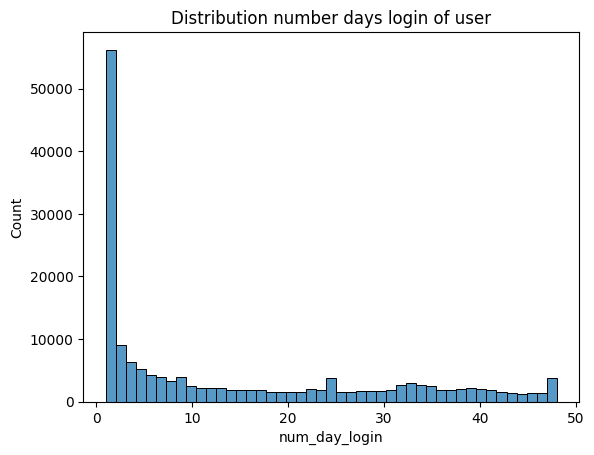

In [21]:
sns.histplot(df_merged['num_day_login'], bins=45)
plt.title('Distribution number days login of user')
plt.show()

In [22]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 16:08:43+0000', tz='UTC'),
 Timestamp('2025-06-19 23:59:59+0000', tz='UTC'))

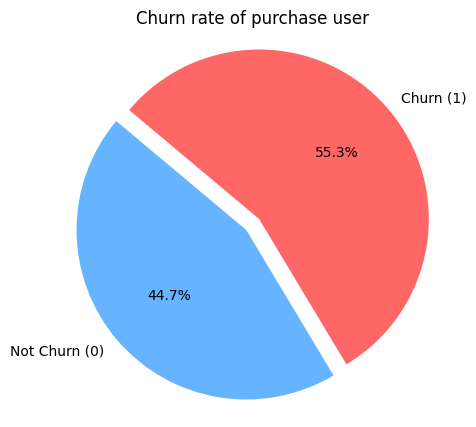

In [23]:
churn_counts = df_merged['churn'].value_counts().sort_index()
labels = ['Not Churn (0)', 'Churn (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(5,5))
plt.pie(
    churn_counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0, 0.1]  
)
plt.title("Churn rate of purchase user")
plt.axis('equal') 
plt.show()

In [24]:
drop_cols = [
    # 'last_update_time_purchase',
    # 'last_update_time_login',
    # 'days_since_last_purchase',
    # 'id_win',
    # 'days_since_last_login',
    # 'first_login_date',
    # 'last_login_date',
    'gold_slope_login',
    'diamond_slope_login',
    'silkcoin_slope_login',
    'popular_time_login',
    'last_update_time_login',
    # 'last_time_in_window',
    # 'event',
    # 'gold_first',
    # 'gold_last',
    # 'diamond_first',
    # 'diamond_last',
    # 'silkcoin_first',
    # 'silkcoin_last',
    # 'gold_max',
    # 'gold_min',
    # 'diamond_max',
    # 'diamond_min',
    # 'silkcoin_max',
    # 'silkcoin_min',
    'level_last_login',
]
df_merged=df_merged.drop(columns=drop_cols,axis=1)

In [25]:
df_merged.columns

Index(['vopenid', 'num_day_login', 'login_frequency', 'avg_between_login',
       'streak_login', 'last_since_from_login', 'gold_std_login',
       'diamond_std_login', 'silkcoin_std_login', 'short_lifetime_flag',
       'powerpoint_last_login', 'vip_last_login', 'churn', 'equi_beha',
       'days_since_last_login'],
      dtype='object')

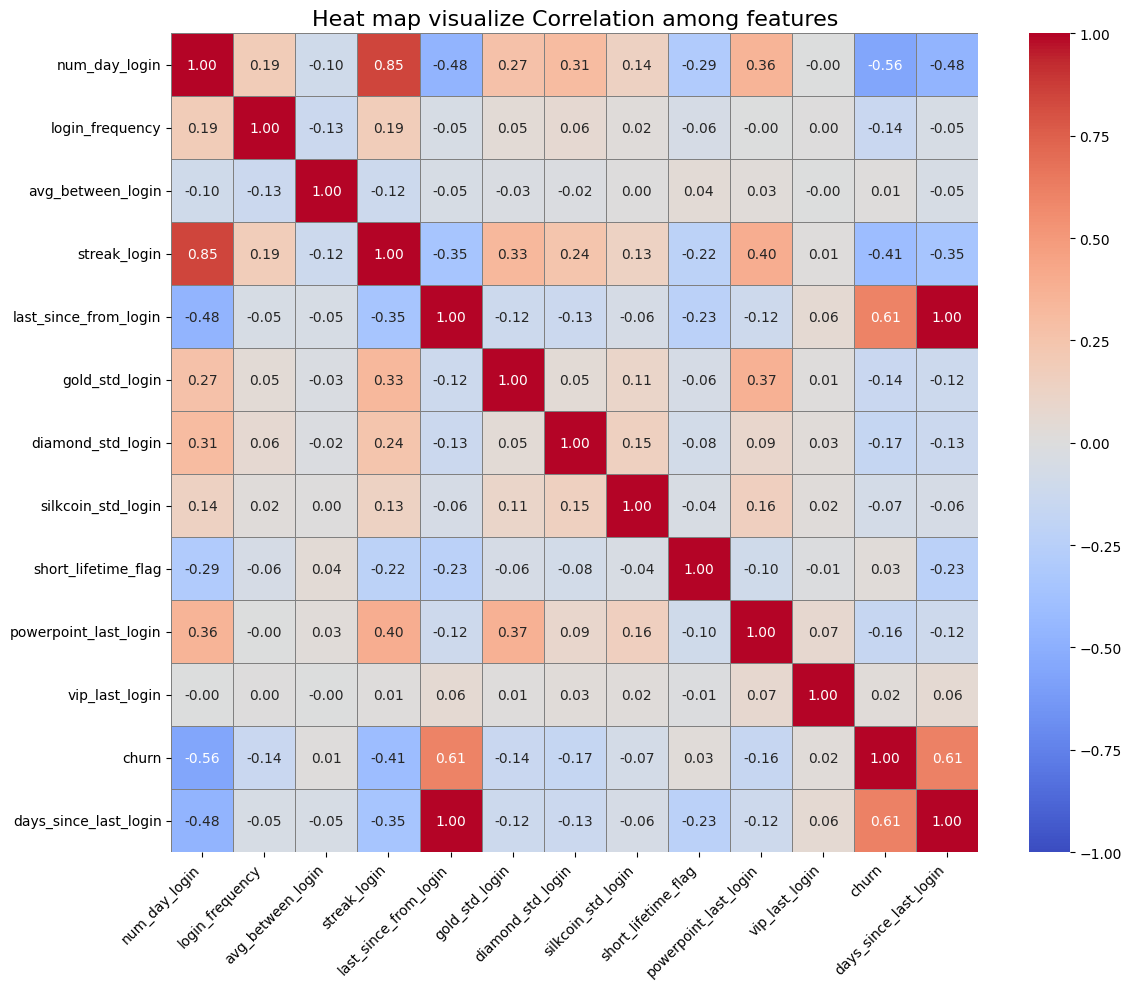

In [26]:
corr_cols = df_merged.drop(columns=['vopenid','equi_beha']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

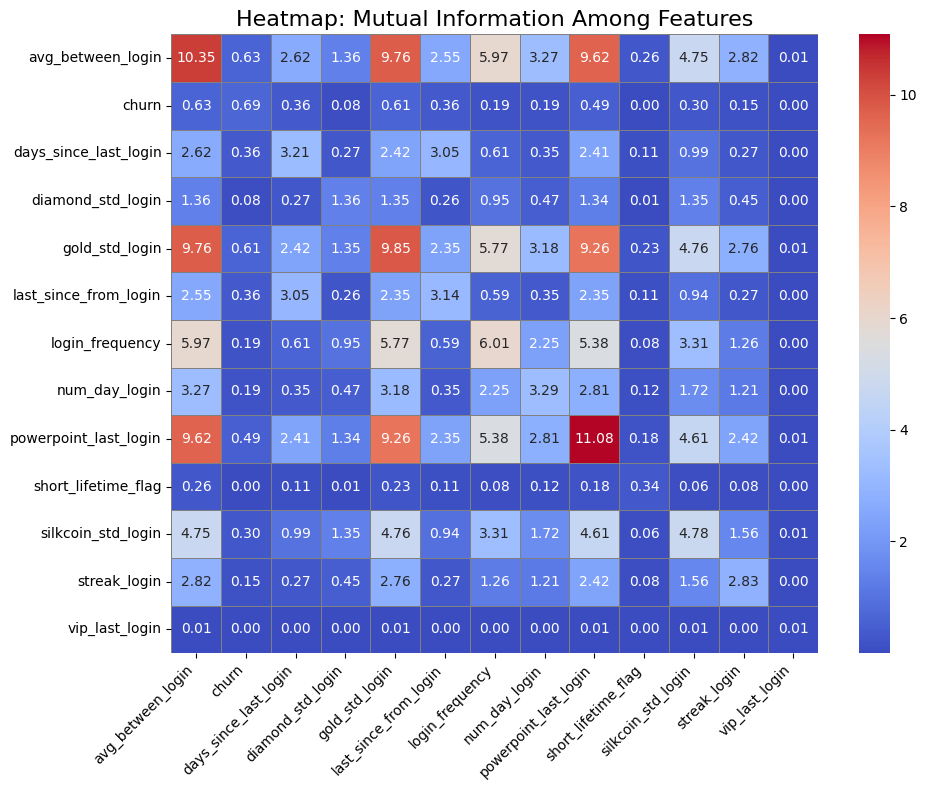

In [27]:
mi_cols = df_merged.columns.difference(['vopenid', 'equi_beha'])

mi_matrix = np.zeros((len(mi_cols), len(mi_cols)))
for i, f1 in enumerate(mi_cols):
    for j, f2 in enumerate(mi_cols):
        mi_matrix[i, j] = mutual_info_score(df_merged[f1], df_merged[f2])


plt.figure(figsize=(10, 8))
sns.heatmap(
    mi_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    xticklabels=mi_cols,
    yticklabels=mi_cols
)

plt.title('Heatmap: Mutual Information Among Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Prepare data**

In [28]:
X=df_merged.drop(columns=['churn','vopenid','powerpoint_last_login','gold_std_login'],axis=1)
y=df_merged['churn']

In [29]:
vopenid_all = df_merged['vopenid']

In [30]:
le=LabelEncoder()
X['equi_beha']=le.fit_transform(X['equi_beha'])

In [31]:
X_train, X_test, y_train, y_test,vopenid_train, vopenid_test = train_test_split(
    X, y, vopenid_all,
    test_size=0.15,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140471, 11), (24789, 11), (140471,), (24789,))

In [32]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [33]:
X_train_cb=X_train.copy()
y_train_cb=y_train.copy()
X_test_cb=X_test.copy()
y_test_cb=y_test.copy()
X_train_cb['equi_beha'] = X_train_cb['equi_beha'].astype(str)
X_test_cb['equi_beha'] = X_test_cb['equi_beha'].astype(str)

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [35]:
X_train.shape,y_train.shape, X_train_scaled.shape,X_test_scaled.shape

((140471, 11), (140471,), (140471, 11), (24789, 11))

### **Modeling**

#### **Logistic Regression**

In [36]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42
    }
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best AUC:", study.best_value)
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-04 11:52:35,591] A new study created in memory with name: no-name-55d82a33-cd07-467d-9b5c-a604ccc22a19
[I 2025-07-04 11:52:42,360] Trial 0 finished with value: 0.9313065140065735 and parameters: {'C': 0.3733259968631427, 'penalty': 'l1', 'solver': 'saga', 'class_weight': None}. Best is trial 0 with value: 0.9313065140065735.
[I 2025-07-04 11:52:48,392] Trial 1 finished with value: 0.9309706426439204 and parameters: {'C': 0.048800478324831906, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9313065140065735.
[I 2025-07-04 11:52:55,151] Trial 2 finished with value: 0.9313045704857107 and parameters: {'C': 3.2008914014864307, 'penalty': 'l1', 'solver': 'saga', 'class_weight': None}. Best is trial 0 with value: 0.9313065140065735.
[I 2025-07-04 11:52:57,522] Trial 3 finished with value: 0.9289587312717428 and parameters: {'C': 0.0010957256414077057, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with v

Best AUC: 0.9313139396359638
  - C: 0.024107602932524858
  - penalty: l1
  - solver: saga
  - class_weight: None


In [37]:
best_params_lr = study.best_params
best_params_lr.update({
    'random_state': 42,
    'n_jobs': -1
})
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.024107602932524858, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')

In [38]:
y_test_pred  = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.8732
Precision: 0.8921
Recall: 0.8766
F1-score: 0.8843
AUC-ROC: 0.9332
Log loss: 0.3486
Brier score: 0.1011

Confusion matrix:
[[ 9630  1453]
 [ 1691 12015]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     11083
           1       0.89      0.88      0.88     13706

    accuracy                           0.87     24789
   macro avg       0.87      0.87      0.87     24789
weighted avg       0.87      0.87      0.87     24789



#### **Extra Trees**

In [39]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-04 12:13:28,217] A new study created in memory with name: no-name-cdd61b14-4397-4a55-8ef1-0c464486f25c
[I 2025-07-04 12:13:33,828] Trial 0 finished with value: 0.959546292908502 and parameters: {'n_estimators': 486, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.959546292908502.
[I 2025-07-04 12:13:41,935] Trial 1 finished with value: 0.9679525476999524 and parameters: {'n_estimators': 467, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 0.8, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9679525476999524.
[I 2025-07-04 12:13:47,534] Trial 2 finished with value: 0.9599344348340193 and parameters: {'n_estimators': 491, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9679525476999524.
[I 2025-07-04 12:13:52,403] Trial 3 finished with va

Best value: 0.9712059565157285
Best params:
  - n_estimators: 486
  - max_depth: 29
  - min_samples_split: 6
  - min_samples_leaf: 2
  - max_features: 0.8
  - class_weight: None


In [40]:
best_params_et = study.best_params
best_params_et.update({
    'random_state': 42,
    'n_jobs': -1
})
et_model = ExtraTreesClassifier(**best_params_et)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=29, max_features=0.8, min_samples_leaf=2,
                     min_samples_split=6, n_estimators=486, n_jobs=-1,
                     random_state=42)

In [41]:
y_test_pred  = et_model.predict(X_test)
y_test_proba = et_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9209
Precision: 0.9187
Recall: 0.9402
F1-score: 0.9293
AUC-ROC: 0.9718
Log loss: 0.2094
Brier score: 0.0597

Confusion matrix:
[[ 9942  1141]
 [  820 12886]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     11083
           1       0.92      0.94      0.93     13706

    accuracy                           0.92     24789
   macro avg       0.92      0.92      0.92     24789
weighted avg       0.92      0.92      0.92     24789



#### **Random Forest**

In [42]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),            
        'max_depth': trial.suggest_int('max_depth', 10, 30),                     
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),      
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-04 12:19:44,511] A new study created in memory with name: no-name-cc4f2232-edea-4d51-b72e-cd7c53f32249
[I 2025-07-04 12:20:17,472] Trial 0 finished with value: 0.9677391293128308 and parameters: {'n_estimators': 488, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 0.8, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9677391293128308.
[I 2025-07-04 12:20:25,017] Trial 1 finished with value: 0.9672454440112416 and parameters: {'n_estimators': 326, 'max_depth': 29, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.9677391293128308.
[I 2025-07-04 12:20:51,612] Trial 2 finished with value: 0.9643961619085009 and parameters: {'n_estimators': 458, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.8, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9677391293128308

Best value: 0.9688161584288968
Best params:
  - n_estimators: 348
  - max_depth: 15
  - min_samples_split: 20
  - min_samples_leaf: 2
  - max_features: 0.8
  - bootstrap: True
  - class_weight: None


In [43]:
best_params_rf = study.best_params
best_params_rf.update({
    'random_state': 42,
    'n_jobs': -1
})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=0.8, min_samples_leaf=2,
                       min_samples_split=20, n_estimators=348, n_jobs=-1,
                       random_state=42)

In [44]:
y_test_pred  = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9167
Precision: 0.9109
Recall: 0.9416
F1-score: 0.9260
AUC-ROC: 0.9694
Log loss: 0.2166
Brier score: 0.0635

Confusion matrix:
[[ 9820  1263]
 [  801 12905]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     11083
           1       0.91      0.94      0.93     13706

    accuracy                           0.92     24789
   macro avg       0.92      0.91      0.92     24789
weighted avg       0.92      0.92      0.92     24789



#### **Extreme Gradient Boosting**

In [45]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,2,5,9.3,10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best values", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-04 12:21:26,878] A new study created in memory with name: no-name-81da8dcc-504f-445f-9464-a16308d8dcbc
[I 2025-07-04 12:21:27,835] Trial 0 finished with value: 0.9663480384611816 and parameters: {'max_depth': 8, 'learning_rate': 0.2420547755148867, 'gamma': 0.9755306927990626, 'min_child_weight': 4, 'colsample_bytree': 0.9785756666115099, 'subsample': 0.9443797010634415, 'reg_alpha': 0.4563524220859162, 'reg_lambda': 0.1381189488255753, 'scale_pos_weight': 2, 'n_estimators': 135}. Best is trial 0 with value: 0.9663480384611816.
[I 2025-07-04 12:21:29,424] Trial 1 finished with value: 0.9615926228265008 and parameters: {'max_depth': 7, 'learning_rate': 0.1522095471463424, 'gamma': 2.9053698868795648, 'min_child_weight': 10, 'colsample_bytree': 0.6148473630887814, 'subsample': 0.9524359462995702, 'reg_alpha': 0.15345363604720602, 'reg_lambda': 0.43915760301475304, 'scale_pos_weight': 2, 'n_estimators': 437}. Best is trial 0 with value: 0.9663480384611816.
[I 2025-07-04 12:21:3

Best values 0.9696137846278514
Best params:
  - max_depth: 12
  - learning_rate: 0.052693294402531426
  - gamma: 0.03360619935199227
  - min_child_weight: 2
  - colsample_bytree: 0.7796889846967459
  - subsample: 0.7257823124484474
  - reg_alpha: 0.4053607890324422
  - reg_lambda: 0.18729509842142433
  - scale_pos_weight: 5
  - n_estimators: 401


In [46]:
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'tree_method': 'hist'
})
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7796889846967459, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.03360619935199227, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.052693294402531426,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=401, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
y_test_pred  = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9087
Precision: 0.8762
Recall: 0.9723
F1-score: 0.9218
AUC-ROC: 0.9704
Log loss: 0.2520
Brier score: 0.0709

Confusion matrix:
[[ 9201  1882]
 [  380 13326]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     11083
           1       0.88      0.97      0.92     13706

    accuracy                           0.91     24789
   macro avg       0.92      0.90      0.91     24789
weighted avg       0.91      0.91      0.91     24789



#### **Light Gradient Boosting Machine**

In [48]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5,9.3, 10]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-04 12:23:53,906] A new study created in memory with name: no-name-0c72728e-8d8a-44ff-909a-4f7834140b66
[I 2025-07-04 12:23:55,916] Trial 0 finished with value: 0.9572970267960548 and parameters: {'n_estimators': 365, 'learning_rate': 0.030767507130043184, 'max_depth': 5, 'num_leaves': 83, 'min_child_samples': 30, 'min_split_gain': 0.28399851168464896, 'subsample': 0.6672774191774868, 'colsample_bytree': 0.8385126096573702, 'reg_alpha': 0.6449415719209355, 'reg_lambda': 0.6351499363349171, 'scale_pos_weight': 5, 'class_weight': None}. Best is trial 0 with value: 0.9572970267960548.
[I 2025-07-04 12:23:56,811] Trial 1 finished with value: 0.9644368418735384 and parameters: {'n_estimators': 159, 'learning_rate': 0.26424171582087275, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 9, 'min_split_gain': 0.7671207790742226, 'subsample': 0.7042827479600173, 'colsample_bytree': 0.881547292652618, 'reg_alpha': 0.8540061419826326, 'reg_lambda': 0.25502830770962237, 'scale_pos_we

Best value: 0.9684520348411425
Best params:
  - n_estimators: 379
  - learning_rate: 0.07097444250225497
  - max_depth: 12
  - num_leaves: 212
  - min_child_samples: 54
  - min_split_gain: 0.009577165415941225
  - subsample: 0.7825057687299958
  - colsample_bytree: 0.994028054767186
  - reg_alpha: 0.6434752572964026
  - reg_lambda: 0.1895886080879372
  - scale_pos_weight: 9.3
  - class_weight: balanced


In [49]:
best_params_lgbm = study.best_params
best_params_lgbm.update({
    'random_state': 42,
    'n_jobs': -1
})
lgbm_model = LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.994028054767186,
               learning_rate=0.07097444250225497, max_depth=12,
               min_child_samples=54, min_split_gain=0.009577165415941225,
               n_estimators=379, n_jobs=-1, num_leaves=212, random_state=42,
               reg_alpha=0.6434752572964026, reg_lambda=0.1895886080879372,
               scale_pos_weight=9.3, subsample=0.7825057687299958)

In [50]:
y_test_pred  = lgbm_model.predict(X_test)
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.8924
Precision: 0.8487
Recall: 0.9801
F1-score: 0.9097
AUC-ROC: 0.9687
Log loss: 0.2925
Brier score: 0.0827

Confusion matrix:
[[ 8689  2394]
 [  273 13433]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     11083
           1       0.85      0.98      0.91     13706

    accuracy                           0.89     24789
   macro avg       0.91      0.88      0.89     24789
weighted avg       0.90      0.89      0.89     24789



#### **CatBoost**

In [51]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 600),
        'depth': trial.suggest_int('depth', 5, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),
        'random_seed': 42,
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', None]),
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train_cb, y_train_cb, cv=5, scoring='roc_auc').mean()
    return score    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f" - {k}: {v}")


[I 2025-07-04 12:31:18,480] A new study created in memory with name: no-name-4c6cd284-23a3-4a7c-bdf7-33c4242b0ea2
[I 2025-07-04 12:31:34,611] Trial 0 finished with value: 0.9603029184868879 and parameters: {'iterations': 312, 'depth': 5, 'learning_rate': 0.13656312009160443, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.9603029184868879.
[I 2025-07-04 12:32:16,649] Trial 1 finished with value: 0.9613958584480151 and parameters: {'iterations': 533, 'depth': 8, 'learning_rate': 0.03062573788862326, 'auto_class_weights': None}. Best is trial 1 with value: 0.9613958584480151.
[I 2025-07-04 12:32:44,712] Trial 2 finished with value: 0.9645464999146304 and parameters: {'iterations': 550, 'depth': 6, 'learning_rate': 0.1435571653362504, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.9645464999146304.
[I 2025-07-04 12:33:14,547] Trial 3 finished with value: 0.9639410971309404 and parameters: {'iterations': 592, 'depth': 6, 'learning_rate': 0.106687348125091

Best value: 0.9670790766347739
Best params:
 - iterations: 563
 - depth: 8
 - learning_rate: 0.1486969611358881
 - auto_class_weights: Balanced


In [52]:
best_params_cb = study.best_params
best_params_cb.update({
    'random_seed': 42,
    'verbose': 0
})

catboost_model = CatBoostClassifier(**best_params_cb, cat_features=['equi_beha'])
catboost_model.fit(X_train_cb, y_train_cb)

In [53]:
y_test_pred_cb = catboost_model.predict(X_test_cb)
y_test_proba_cb = catboost_model.predict_proba(X_test_cb)[:, 1]

print(f"Accuracy: {accuracy_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"Precision: {precision_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"Recall: {recall_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"F1-score: {f1_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_cb, y_test_proba_cb):.4f}")
print(f"Log loss: {log_loss(y_test_cb, y_test_proba_cb):.4f}")
print(f"Brier score: {brier_score_loss(y_test_cb, y_test_proba_cb):.4f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test_cb, y_test_pred_cb))
print("\nClassification report:")
print(classification_report(y_test_cb, y_test_pred_cb))

Accuracy: 0.9143
Precision: 0.9176
Recall: 0.9283
F1-score: 0.9229
AUC-ROC: 0.9670
Log loss: 0.2253
Brier score: 0.0654

Confusion matrix:
[[ 9941  1142]
 [  983 12723]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     11083
           1       0.92      0.93      0.92     13706

    accuracy                           0.91     24789
   macro avg       0.91      0.91      0.91     24789
weighted avg       0.91      0.91      0.91     24789



#### **Voting Classifier**

In [54]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(**best_params_lr)
)
et_model = ExtraTreesClassifier(**best_params_et)
rf_model = RandomForestClassifier(**best_params_rf)
xgb_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)
cb_model = make_pipeline(
    FunctionTransformer(lambda X: X.assign(equip_beha=X['equi_beha'].astype(str))),
    CatBoostClassifier(**best_params_cb, cat_features=['equi_beha'])
)

In [55]:
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('et',et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cb',cb_model),
    ],
    voting='soft' 
)

voting_model.fit(X_train, y_train)  

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.024107602932524858,
                                                                  n_jobs=-1,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='saga'))])),
                             ('et',
                              ExtraTreesClassifier(max_depth=29,
                                                   max_features=0.8,
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=486, n_jobs=-1,
                                                   random_state=42)),...
                                             num_leaves=212, random_state=42,
                                             reg_alpha=0.6434752572964026,
                                             reg_lambda=0.1895886080879372,
                                             scale_pos_weight=9.3,
                                             subsample=0.7825057687299958)),
                             ('cb',
                              Pipeline(steps=[('functiontransformer',
                                               FunctionTransformer(func=<function <lambda> at 0x00000133C1108360>)),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x00000133CDC9E2A0>)]))],
                 voting='soft')

In [56]:
y_test_proba_voting = voting_model.predict_proba(X_test)[:, 1]
y_test_pred_voting  = voting_model.predict(X_test)

In [57]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_voting):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_voting):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_voting):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_voting):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_proba_voting):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba_voting):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_voting))

Accuracy: 0.9171
Precision: 0.8969
Recall: 0.9604
F1-score: 0.9276
AUC-ROC: 0.9694
Log Loss: 0.2221
Brier Score: 0.0639

Confusion Matrix:
[[ 9570  1513]
 [  543 13163]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     11083
           1       0.90      0.96      0.93     13706

    accuracy                           0.92     24789
   macro avg       0.92      0.91      0.92     24789
weighted avg       0.92      0.92      0.92     24789



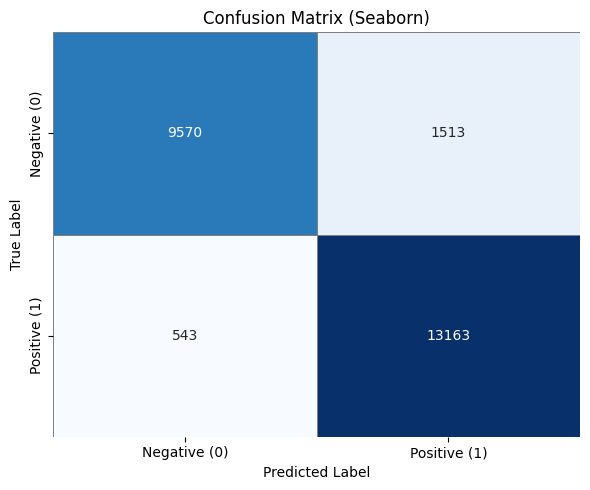

In [58]:
cm = confusion_matrix(y_test, y_test_pred_voting)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

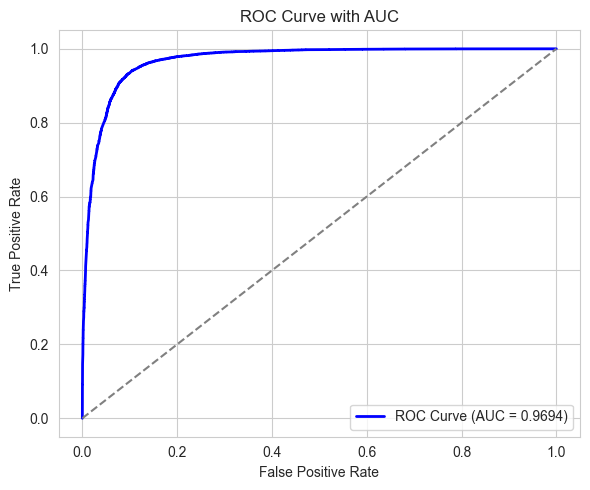

In [59]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_voting)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [60]:
df_res_voting = pd.DataFrame({
    'vopenid': vopenid_test,
    'true_label': y_test,
    'predicted_label': y_test_pred_voting,
    'proba': y_test_proba_voting
})

df_res_voting = df_res_voting.merge(df_merged, on='vopenid', how='left')
df_res_voting

,vopenid,true_label,predicted_label,proba,num_day_login,login_frequency,avg_between_login,streak_login,last_since_from_login,gold_std_login,diamond_std_login,silkcoin_std_login,short_lifetime_flag,powerpoint_last_login,vip_last_login,churn,equi_beha,days_since_last_login
0,2501042153055312,0,0,0.01,41,1.27,0.91,19,0,511311.49,155.58,88.14,0,6114409,0,0,not_enhance,6
1,2505091356379406,1,1,1.00,1,8.00,0.05,1,41,2032.79,0.00,0.00,0,25139,0,1,not_enhance,48
2,2407090337322545,1,1,0.86,2,3.50,2.00,1,12,123333.79,0.00,28.77,0,125132,0,1,not_enhance,19
3,2501071619099563,0,0,0.05,13,1.00,3.86,9,0,136456.90,0.00,0.00,0,1015602,0,0,not_enhance,7
4,2506191847205800,1,1,0.58,1,1.00,0.00,1,0,0.00,0.00,0.00,1,25087,0,1,not_enhance,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24784,2504022207195533,1,1,0.90,5,1.80,3.57,2,17,10293.74,0.00,0.00,0,285388,0,1,not_enhance,24
24785,2410131012099016,0,0,0.03,30,1.70,0.90,14,0,142536.76,61.06,59.61,0,2164087,0,0,not_enhance,7
24786,2506050306206510,0,0,0.03,14,7.36,0.15,11,0,72932.62,0.00,0.00,0,34528,0,0,not_enhance,6
24787,2506050802340411,1,1,0.96,2,10.00,0.06,2,13,91215.17,0.00,0.00,0,114780,0,1,not_enhance,20


#### **Stacking Classifier**

In [61]:
stacking_model = StackingClassifier(
    estimators=[
        ('lr',lr_model),
        ('et', et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cb',cb_model),
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
    
stacking_model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=0.024107602932524858,
                                                                    n_jobs=-1,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='saga'))])),
                               ('et',
                                ExtraTreesClassifier(max_depth=29,
                                                     max_features=0.8,
                                                     min_samples_leaf=2,
                                                     min_samples_split=6,
                                                     n_estimators=486,
                                                     n_jobs=-1,
                                                     random_stat...
                                               reg_lambda=0.1895886080879372,
                                               scale_pos_weight=9.3,
                                               subsample=0.7825057687299958)),
                               ('cb',
                                Pipeline(steps=[('functiontransformer',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000133C1108360>)),
                                                ('catboostclassifier',
                                                 <catboost.core.CatBoostClassifier object at 0x00000133CDC9E2A0>)]))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

In [62]:
y_test_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]
y_test_pred_stacking  = stacking_model.predict(X_test)

In [63]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_stacking):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_stacking):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_stacking):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_stacking):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba_stacking):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba_stacking):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred_stacking))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred_stacking))

Accuracy: 0.9218
Precision: 0.9220
Recall: 0.9379
F1-score: 0.9299
AUC-ROC: 0.9722
Log loss: 0.2147
Brier score: 0.0604

Confusion matrix:
[[ 9996  1087]
 [  851 12855]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     11083
           1       0.92      0.94      0.93     13706

    accuracy                           0.92     24789
   macro avg       0.92      0.92      0.92     24789
weighted avg       0.92      0.92      0.92     24789



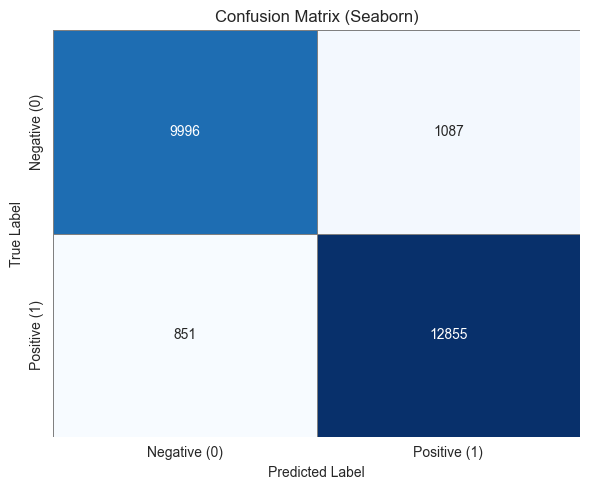

In [64]:
cm = confusion_matrix(y_test, y_test_pred_stacking)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

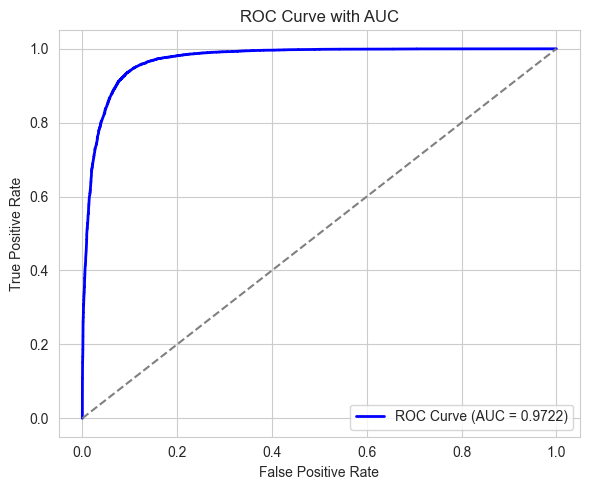

In [65]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [66]:
df_res_stacking = pd.DataFrame({
    'vopenid': vopenid_test,
    'true_label': y_test,
    'predicted_label': y_test_pred_stacking,
    'proba': y_test_proba_stacking
})

df_res_stacking = df_res_stacking.merge(df_merged, on='vopenid', how='left')
df_res_stacking

,vopenid,true_label,predicted_label,proba,num_day_login,login_frequency,avg_between_login,streak_login,last_since_from_login,gold_std_login,diamond_std_login,silkcoin_std_login,short_lifetime_flag,powerpoint_last_login,vip_last_login,churn,equi_beha,days_since_last_login
0,2501042153055312,0,0,0.01,41,1.27,0.91,19,0,511311.49,155.58,88.14,0,6114409,0,0,not_enhance,6
1,2505091356379406,1,1,0.96,1,8.00,0.05,1,41,2032.79,0.00,0.00,0,25139,0,1,not_enhance,48
2,2407090337322545,1,1,0.88,2,3.50,2.00,1,12,123333.79,0.00,28.77,0,125132,0,1,not_enhance,19
3,2501071619099563,0,0,0.01,13,1.00,3.86,9,0,136456.90,0.00,0.00,0,1015602,0,0,not_enhance,7
4,2506191847205800,1,0,0.39,1,1.00,0.00,1,0,0.00,0.00,0.00,1,25087,0,1,not_enhance,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24784,2504022207195533,1,1,0.90,5,1.80,3.57,2,17,10293.74,0.00,0.00,0,285388,0,1,not_enhance,24
24785,2410131012099016,0,0,0.02,30,1.70,0.90,14,0,142536.76,61.06,59.61,0,2164087,0,0,not_enhance,7
24786,2506050306206510,0,0,0.01,14,7.36,0.15,11,0,72932.62,0.00,0.00,0,34528,0,0,not_enhance,6
24787,2506050802340411,1,1,0.95,2,10.00,0.06,2,13,91215.17,0.00,0.00,0,114780,0,1,not_enhance,20


In [67]:
df_res_stacking.tail(5)

,vopenid,true_label,predicted_label,proba,num_day_login,login_frequency,avg_between_login,streak_login,last_since_from_login,gold_std_login,diamond_std_login,silkcoin_std_login,short_lifetime_flag,powerpoint_last_login,vip_last_login,churn,equi_beha,days_since_last_login
24784,2504022207195533,1,1,0.90,5,1.80,3.57,2,17,10293.74,0.00,0.00,0,285388,0,1,not_enhance,24
24785,2410131012099016,0,0,0.02,30,1.70,0.90,14,0,142536.76,61.06,59.61,0,2164087,0,0,not_enhance,7
24786,2506050306206510,0,0,0.01,14,7.36,0.15,11,0,72932.62,0.00,0.00,0,34528,0,0,not_enhance,6
24787,2506050802340411,1,1,0.95,2,10.00,0.06,2,13,91215.17,0.00,0.00,0,114780,0,1,not_enhance,20
24788,2505182348394962,0,0,0.02,13,4.77,0.52,4,0,90081.36,0.00,4.63,0,36185,0,0,not_enhance,7


In [68]:
df_stack_false=df_res_stacking[(df_res_stacking['true_label']!=df_res_stacking['predicted_label'])]

In [69]:
df_stack_false[['vopenid','true_label','predicted_label','proba']].to_csv("check_nonp.csv",header=True,index=False)

In [70]:
df_cluster_purchase=pd.read_csv("user_purchase_clusters.csv",dtype={"vopenid":"object"})
df_cluster_purchase.shape

(37259, 10)

In [72]:
df_cluster_engag=pd.read_csv("user_engagement_clusters.csv",dtype={"vopenid":"object"})
df_cluster_engag.shape

(161043, 10)

In [73]:
df_res_stacking=df_res_stacking[['vopenid','true_label','predicted_label']]
df_cluster_engag = df_cluster_engag.merge(df_res_stacking, on='vopenid', how='left')
df_cluster_engag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161043 entries, 0 to 161042
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vopenid                161043 non-null  object 
 1   last_update_time       161043 non-null  object 
 2   num_day_login          161043 non-null  int64  
 3   streak_login           161043 non-null  int64  
 4   last_since_from_login  161043 non-null  int64  
 5   login_frequency        161043 non-null  float64
 6   kmeans_cluster         161043 non-null  int64  
 7   pca_kmean_1            161043 non-null  float64
 8   pca_kmean_2            161043 non-null  float64
 9   name_cluster           161043 non-null  object 
 10  true_label             18874 non-null   float64
 11  predicted_label        18874 non-null   float64
dtypes: float64(5), int64(4), object(3)
memory usage: 14.7+ MB


In [ ]:
df_res_stacking[df_res_stacking['vopenid']=="2505182153561626"]

,vopenid,true_label,predicted_label
10417,2505182153561626,1,1
